**First we load and merge train, val and test datasets**

In [1]:
import sys
sys.path.append('..')
from src.data_loader import load_dataset

# Load data (Train+Val combined, Test kept separate)
df_train_full, df_test = load_dataset("../data")

print(f"✅ Training Pool Size: {len(df_train_full)}")
print(f"🔒 Official Test Size:  {len(df_test)}")

✅ Training Pool Size: 7289
🔒 Official Test Size:  1576


**Analysis of class balance**

✅ Auto-detected 20 label columns.
🔍 First few: ['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement']
📊 Training Set Balance ANALYSIS (N=7289)
----------------------------------------
                            Count  Percentage
Universalism: concern        2768   37.975031
Security: personal           2759   37.851557
Security: societal           2216   30.401976
Achievement                  2087   28.632185
Benevolence: caring          1965   26.958431
Self-direction: action       1891   25.943202
Conformity: rules            1632   22.389903
Universalism: objectivity    1425   19.550007
Self-direction: thought      1239   16.998216
Benevolence: dependability   1074   14.734531
Universalism: tolerance       887   12.169022
Power: dominance              774   10.618741
Power: resources              757   10.385512
Tradition                     740   10.152284
Universalism: nature          554    7.600494
Humility                      522    7.

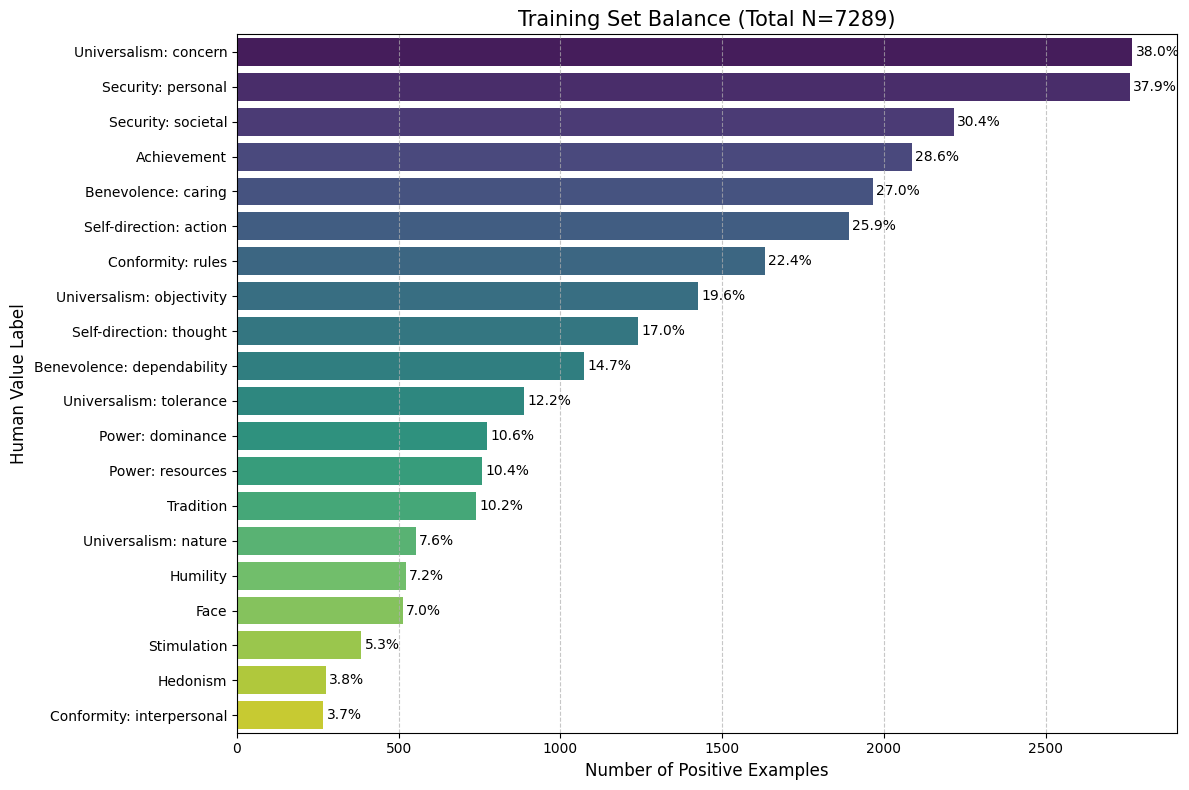

In [2]:
import numpy as np
from src.visualization import plot_class_distribution

# 1. Feature Selection
# Only select columns that are Numbers (Integers/Floats)
label_cols = df_train_full.select_dtypes(include=['number']).columns.tolist()

# 2. Exclude 'Argument ID' if it was selected (it is a number, but not a label)
if 'Argument ID' in label_cols:
    label_cols.remove('Argument ID')

# 3. Double Check
print(f"✅ Auto-detected {len(label_cols)} label columns.")
print(f"🔍 First few: {label_cols[:5]}")

# 4. Run Analysis
plot_class_distribution(df_train_full, label_cols, title="Training Set Balance")

**Visualize examples**

In [3]:
from src.visualization import display_random_examples

display_random_examples(df_train_full, n=5)

🆔 ID: A19070
📢 CONCLUSION: We should ban missionary work
⚖️ STANCE: against
📝 PREMISE: missionaries are necessary as they provide education, health care, and more to those in need.
------------------------------
🧠 ACTUAL HUMAN VALUES:
   ✅ Self-direction: thought
   ✅ Achievement
   ✅ Power: dominance
   ✅ Security: personal
   ✅ Tradition
   ✅ Universalism: concern

🆔 ID: A18084
📢 CONCLUSION: We should ban missionary work
⚖️ STANCE: against
📝 PREMISE: independent religious organisations should be free to solicit for new members if they do so in a fair and open manner.
------------------------------
🧠 ACTUAL HUMAN VALUES:
   ✅ Self-direction: thought
   ✅ Self-direction: action
   ✅ Tradition
   ✅ Universalism: tolerance

🆔 ID: A30313
📢 CONCLUSION: We should subsidize Wikipedia
⚖️ STANCE: against
📝 PREMISE: subsidizing wikipedia would lead to bias in its articles and slanted information
------------------------------
🧠 ACTUAL HUMAN VALUES:
   ✅ Benevolence: caring
   ✅ Universalism: ob

**Why we need `iterative-stratification`**

Standard Scikit-Learn tools are designed for **Single-Label** problems (is this a Cat **OR** a Dog?). They choke on **Multi-Label** data like ours (is this Security **AND** Tradition?).

If we try to use standard stratification, the code will either crash or ignore half your labels.

**This library saves us by:**
* **Balancing every tag:** It ensures we don't accidentally end up with a test set that has zero examples of rare values like *Stimulation*.
* **Respecting complexity:** It makes sure the *combinations* of values are split evenly, so our model learns the real patterns.

In [4]:
# !uv pip install iterative-stratification

In [5]:
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from src.preprocessing import create_text_features

# 1. Prepare Features
df_train_full = create_text_features(df_train_full)

# 2. Define Features and Labels
X_pool = df_train_full['text'].values
y_pool = df_train_full[label_cols].values

print(f"Pool shape: {X_pool.shape}")

# 3. Create a MultilabelStratifiedShuffleSplit object (Iterative Stratification)
# This ensures a balanced multilabel distribution
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in msss.split(X_pool, y_pool):
    X_train, X_val = X_pool[train_index], X_pool[val_index]
    y_train, y_val = y_pool[train_index], y_pool[val_index]

print("-" * 30)
print(f"✅ Final Training Set:   {X_train.shape[0]} examples (For fitting models)")
print(f"🧪 Internal Validation:  {X_val.shape[0]} examples (For tuning hyperparameters)")

Pool shape: (7289,)
------------------------------
✅ Final Training Set:   5832 examples (For fitting models)
🧪 Internal Validation:  1457 examples (For tuning hyperparameters)


[nltk_data] Downloading package stopwords to /home/alumno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alumno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alumno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alumno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**Visualizing the balacing of this new stratified splitting**

/home/alumno/Desktop/datos/NLP/assigment_1/notebooks/../src/visualization.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(strat_df['Label'], rotation=45, ha='right')


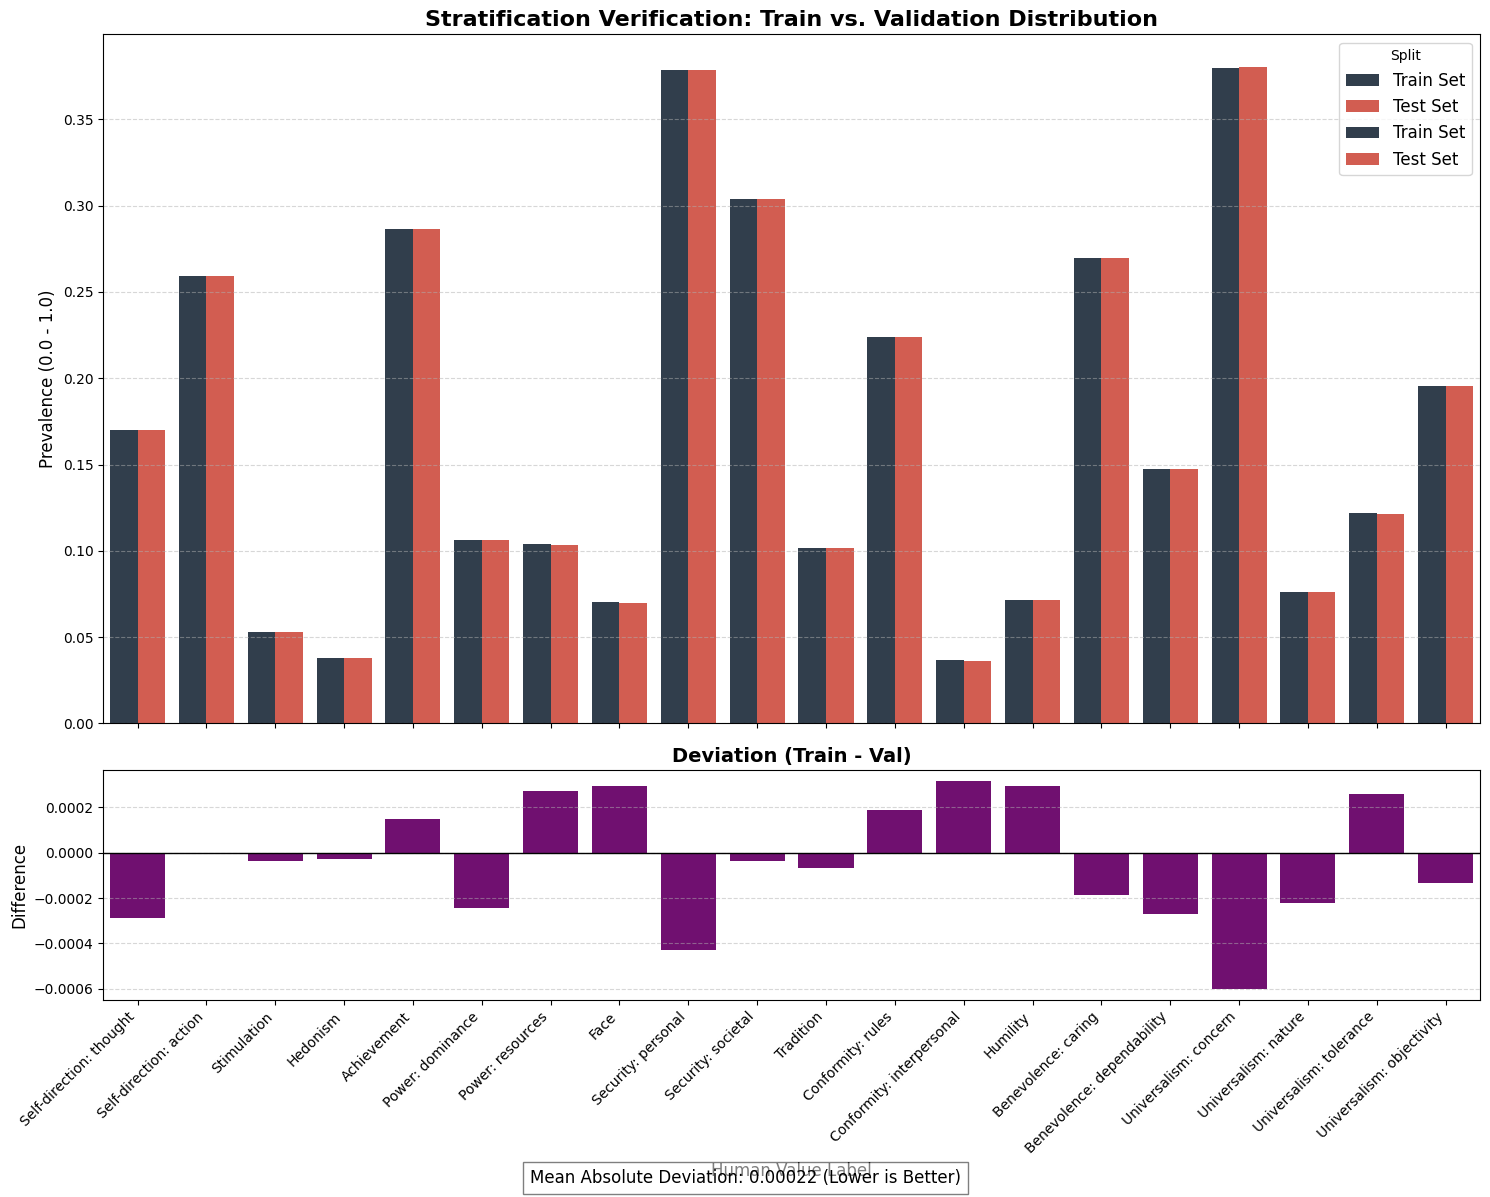

In [6]:
from src.visualization import plot_stratification_check

# Check if our Train/Validation split preserved the label distribution
# We compare y_train vs y_val here
plot_stratification_check(y_train, y_val, label_cols, filename="stratification_train_val.png")